In [10]:
!pip install yfinance pandas matplotlib

  Using cached yfinance-0.2.66-py2.py3-none-any.whl.metadata (6.0 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     ---------------------------------------- 0.0/949.2 kB ? eta -:--:--
     ---------------------------------------- 10.2/949.2 kB ? eta -:--:--
     - ----------------------------------- 30.7/949.2 kB 435.7 kB/s eta 0:00:03
     - ----------------------------------- 41.0/949.2 kB 393.8 kB/s eta 0:00:03
     -- ---------------------------------- 61.4/949.2 kB 328.2 kB/s eta 0:00:03
     --- --------------------------------- 92.2/949.2 kB 374.1 kB/s eta 0:00:03
     --- --------------------------------- 92.2/949.2 kB 374.1 kB/s eta 0:00:03
     --- --------------------------------- 92.2/949.2 kB 374.1 kB/s eta 0:00:03
     --- --------------------------------- 92.2/949.2 kB 374.1 kB/s eta 0:00:03
     ---- ------------------------------- 122.9/949.2 kB 277.4 kB/s eta 0:00:03
     ----- ------------------------------

In [5]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [9]:
gold = yf.download("GC=F", start="2015-06-01", end="2025-06-01", interval="1mo")

C:\Users\hp\AppData\Local\Temp\ipykernel_20076\2391898876.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  gold = yf.download("GC=F", start="2015-06-01", end="2025-06-01", interval="1mo")
[*********************100%***********************]  1 of 1 completed


In [11]:
gold.to_csv("gold_prices.csv")
print("File saved successfully!")

File saved successfully!


In [13]:

# Skip the first two rows (ticker + fake headers)
df = pd.read_csv("gold_prices.csv", skiprows=[0,1])

#Rename columns properly
df.columns = ['Date', 'Close', 'High', 'Low', 'Open', 'Volume']

# Convert 'Date' to datetime and set as index
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
df = df.set_index('Date')

#Reorder columns correctly
df = df[['Open', 'High', 'Low', 'Close', 'Volume']]

# Convert numeric columns
df = df.apply(pd.to_numeric, errors='coerce')

#  Clean and sort
df = df.dropna().sort_index()
df = df.reset_index()

print(df.head())


        Date         Open         High          Low        Close  Volume
0 2015-06-01  1190.599976  1204.000000  1164.000000  1171.500000    6252
1 2015-07-01  1173.099976  1173.099976  1078.599976  1094.900024  216892
2 2015-08-01  1095.500000  1169.000000  1080.500000  1131.599976   13251
3 2015-09-01  1133.500000  1155.900024  1098.199951  1115.500000    9119
4 2015-10-01  1115.199951  1189.000000  1105.800049  1141.500000    4321


In [15]:
# Make sure the index is a datetime type
gold.index = pd.to_datetime(gold.index)
gold = gold.sort_index()  # just in case

# Check for missing values
print("Missing values in each column:")
print(gold.isnull().sum())

# Fill missing values with the previous available value
gold = gold.fillna(method='ffill')

# Add moving averages as new features
gold["MA3"] = gold['Close'].rolling(window=3).mean()
gold["MA6"] = gold['Close'].rolling(window=6).mean()

# Add a daily (actually monthly) change feature
gold['Change'] = gold['Close'] - gold['Open']

# Drop rows with any remaining NaN values (from moving averages)
gold = gold.dropna()

# Show the updated dataframe
print(gold.head())

Missing values in each column:
Price   Ticker
Close   GC=F      0
High    GC=F      0
Low     GC=F      0
Open    GC=F      0
Volume  GC=F      0
dtype: int64
Price             Close         High          Low         Open  Volume  \
Ticker             GC=F         GC=F         GC=F         GC=F    GC=F   
Date                                                                     
2015-12-01  1060.300049  1098.800049  1046.199951  1064.599976   10149   
2016-01-01  1116.400024  1125.699951  1063.199951  1063.400024  229558   
2016-02-01  1233.900024  1260.800049  1115.300049  1116.699951   13930   
2016-03-01  1234.199951  1280.699951  1210.000000  1240.500000  244751   
2016-04-01  1289.199951  1295.500000  1209.199951  1232.300049    9954   

Price               MA3          MA6      Change  
Ticker                                            
Date                                              
2015-12-01  1105.766683  1119.216675   -4.299927  
2016-01-01  1106.066691  1110.033346   53.00

C:\Users\hp\AppData\Local\Temp\ipykernel_20076\1612872133.py:10: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  gold = gold.fillna(method='ffill')


In [17]:
# the features and target variable
feature_cols = ['Open', 'High', 'Low', 'Volume', 'MA3', 'MA6', 'Change']
X = gold[feature_cols]
y = gold['Close']

In [19]:
#Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [21]:
#Train your models
# Linear Regression
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

In [23]:
# Random Forest
rf = RandomForestRegressor()
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

C:\Users\hp\anaconda3\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


In [33]:
#Evaluate the models
print("---- Linear Regression ----")
print("MAE:", mean_absolute_error(y_test, y_pred_lr))
print("MSE:", mean_squared_error(y_test, y_pred_lr))

print("\n---- Random Forest ----")
print("MAE:", mean_absolute_error(y_test, y_pred_rf))
print("MSE:", mean_squared_error(y_test, y_pred_rf))

---- Linear Regression ----
MAE: 2.0463630789890885e-12
MSE: 4.74077888569454e-24

---- Random Forest ----
MAE: 44.336398803710935
MSE: 4148.869159164642


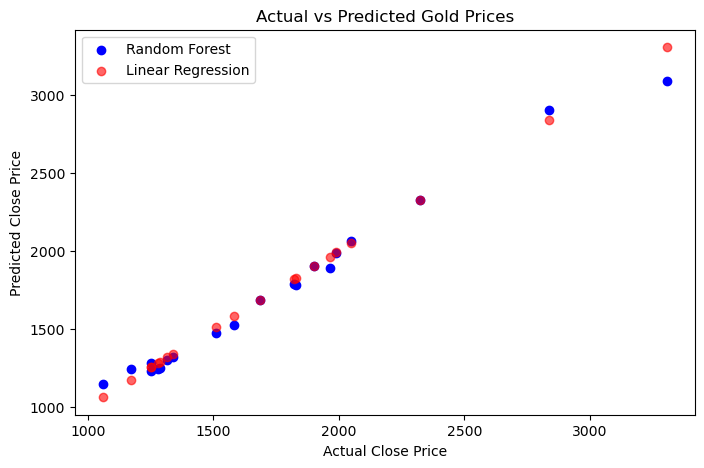

In [35]:
#Visualize actual vs predicted values
plt.figure(figsize=(8,5))
plt.scatter(y_test, y_pred_rf, color='blue', label='Random Forest')
plt.scatter(y_test, y_pred_lr, color='red', alpha=0.6, label='Linear Regression')
plt.xlabel('Actual Close Price')
plt.ylabel('Predicted Close Price')
plt.title('Actual vs Predicted Gold Prices')
plt.legend()
plt.show()

In [40]:
pip install prophet

Note: you may need to restart the kernel to use updated packages.


12:04:39 - cmdstanpy - INFO - Chain [1] start processing
12:04:39 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\hp\anaconda3\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


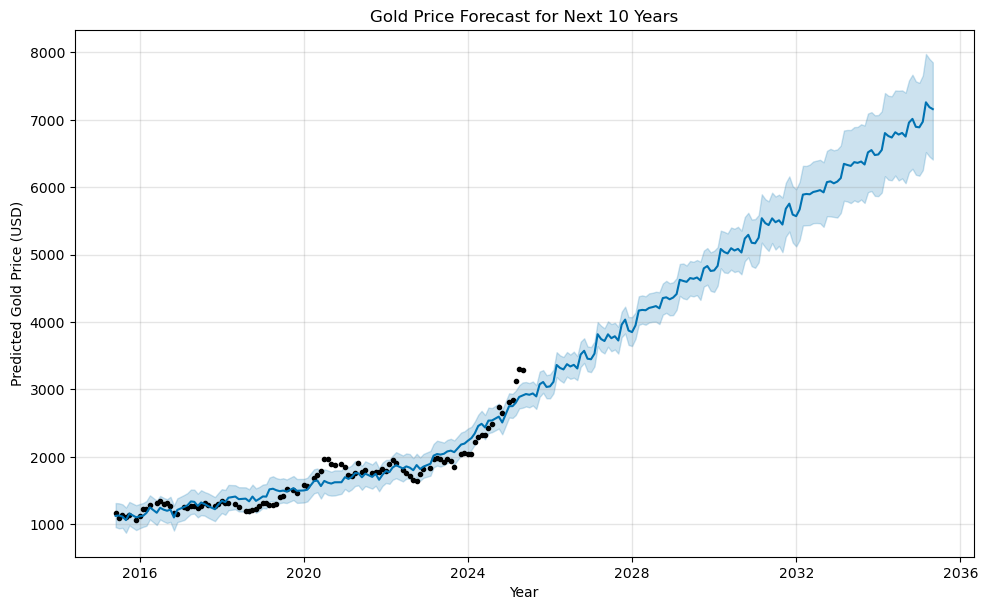

In [41]:
from prophet import Prophet
import pandas as pd
import matplotlib.pyplot as plt

# Load your cleaned dataset
gold = pd.read_csv("gold_prices.csv", skiprows=[0,1])
gold.columns = ['Date', 'Close', 'High', 'Low', 'Open', 'Volume']
gold['Date'] = pd.to_datetime(gold['Date'])
gold = gold[['Date', 'Close']].dropna()

# Prophet needs columns named 'ds' (date) and 'y' (value)
data = gold.rename(columns={'Date': 'ds', 'Close': 'y'})

# Initialize and fit the model
model = Prophet()
model.fit(data)

# Create future dataframe for 10 years (120 months)
future = model.make_future_dataframe(periods=120, freq='M')

# Predict future values
forecast = model.predict(future)

# Plot forecast
model.plot(forecast)
plt.title("Gold Price Forecast for Next 10 Years")
plt.xlabel("Year")
plt.ylabel("Predicted Gold Price (USD)")
plt.show()


In [50]:
!jupyter nbconvert --to html Gold_Price_Prediction_Forecasting.ipynb

[NbConvertApp] Converting notebook Gold_Price_Prediction_Forecasting.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 2 image(s).
[NbConvertApp] Writing 465350 bytes to Gold_Price_Prediction_Forecasting.html
